In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [8]:
dataset = dataset.dropna()

In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

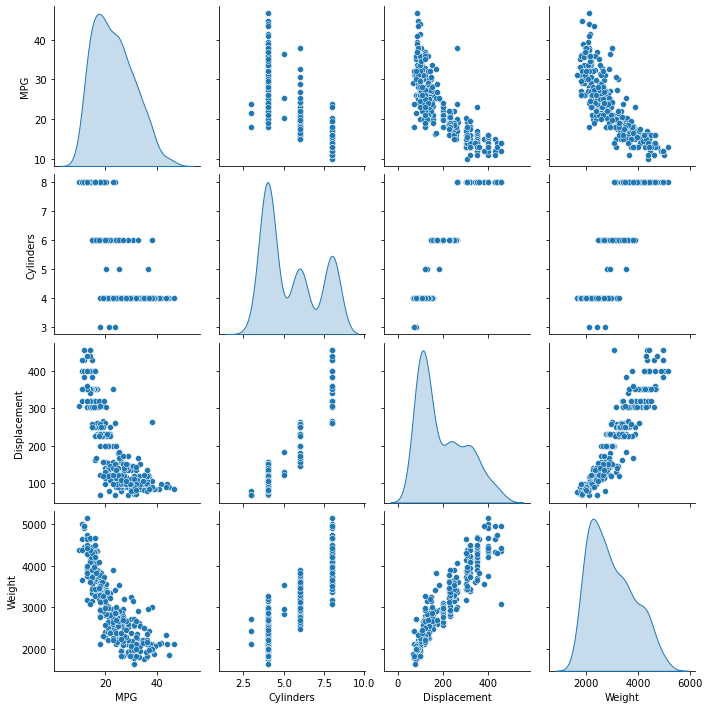

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [17]:
normalizer = preprocessing.Normalization()

In [18]:
normalizer.adapt(np.array(train_features))

In [19]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [21]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [23]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [24]:
horsepower_model.predict(horsepower[:10])

array([[-1.053],
       [-0.595],
       [ 1.944],
       [-1.477],
       [-1.336],
       [-0.524],
       [-1.582],
       [-1.336],
       [-0.348],
       [-0.595]], dtype=float32)

In [25]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [26]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 7.01 s, sys: 740 ms, total: 7.75 s
Wall time: 9.05 s


In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802709,4.185330,95
96,3.803073,4.192924,96
97,3.803889,4.190530,97
98,3.803941,4.191652,98
99,3.801839,4.198693,99


In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

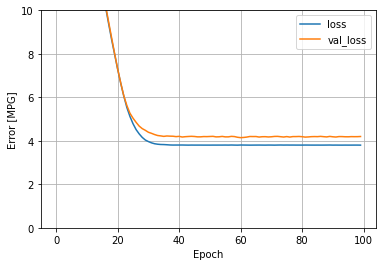

In [29]:
plot_loss(history)

Collect the results on the test set, for later:

In [30]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [31]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [32]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

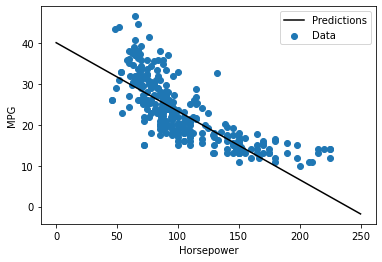

In [33]:
plot_horsepower(x,y)

In [46]:
horsepower_model.weights 

[<tf.Variable 'mean:0' shape=(1,) dtype=float32, numpy=array([104.869], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(1,) dtype=float32, numpy=array([1446.699], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=314>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-6.377]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([22.542], dtype=float32)>]

In [52]:
horsepower_model.get_layer("dense_1").bias.numpy()

array([22.542], dtype=float32)

In [34]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [35]:
linear_model.predict(train_features[:10])

array([[ 0.788],
       [-0.657],
       [-0.374],
       [-0.235],
       [-0.783],
       [-1.109],
       [-0.852],
       [-0.409],
       [-0.283],
       [-0.11 ]], dtype=float32)

In [36]:
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.166],
       [-0.734],
       [ 0.399],
       [-0.347],
       [-0.436],
       [-0.349],
       [ 0.262],
       [-0.432],
       [-0.375]], dtype=float32)>

In [37]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [38]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 6.74 s, sys: 415 ms, total: 7.16 s
Wall time: 7.11 s


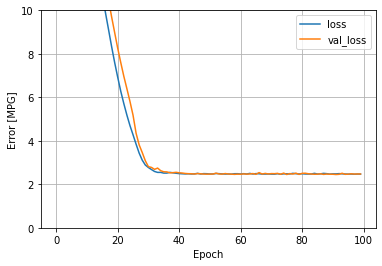

In [39]:
plot_loss(history)

In [40]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [54]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), 
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [55]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [56]:
dnn_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [57]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.11 s, sys: 709 ms, total: 7.82 s
Wall time: 7.32 s


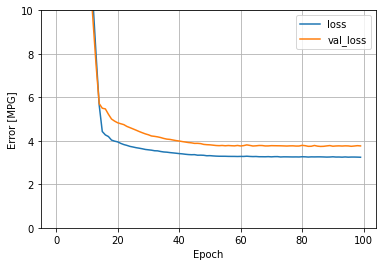

In [58]:
plot_loss(history)

In [59]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

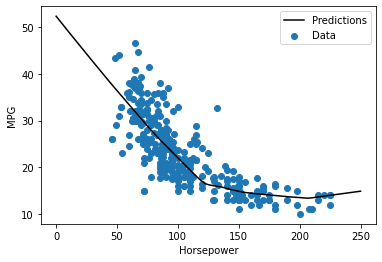

In [62]:
plot_horsepower(x, y) 

Collect the results on the test set, for later:

In [63]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [64]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [68]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
8/8 - 0s - loss: 1.3703 - val_loss: 2.1277
Epoch 2/100
8/8 - 0s - loss: 1.3686 - val_loss: 2.1579
Epoch 3/100
8/8 - 0s - loss: 1.3876 - val_loss: 2.1517
Epoch 4/100
8/8 - 0s - loss: 1.3877 - val_loss: 2.1044
Epoch 5/100
8/8 - 0s - loss: 1.3895 - val_loss: 2.1303
Epoch 6/100
8/8 - 0s - loss: 1.3750 - val_loss: 2.1499
Epoch 7/100
8/8 - 0s - loss: 1.4067 - val_loss: 2.1428
Epoch 8/100
8/8 - 0s - loss: 1.3762 - val_loss: 2.1154
Epoch 9/100
8/8 - 0s - loss: 1.3845 - val_loss: 2.1279
Epoch 10/100
8/8 - 0s - loss: 1.3903 - val_loss: 2.1539
Epoch 11/100
8/8 - 0s - loss: 1.3818 - val_loss: 2.1243
Epoch 12/100
8/8 - 0s - loss: 1.3835 - val_loss: 2.1516
Epoch 13/100
8/8 - 0s - loss: 1.3788 - val_loss: 2.1032
Epoch 14/100
8/8 - 0s - loss: 1.3540 - val_loss: 2.1463
Epoch 15/100
8/8 - 0s - loss: 1.3734 - val_loss: 2.1592
Epoch 16/100
8/8 - 0s - loss: 1.3992 - val_loss: 2.1186
Epoch 17/100
8/8 - 0s - loss: 1.4278 - val_loss: 2.1359
Epoch 18/100
8/8 - 0s - loss: 1.3866 - val_loss: 2.0565
E

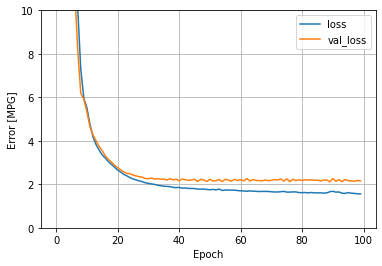

In [66]:
plot_loss(history)

In [69]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0) 

In [70]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.655363
linear_model,2.501311
dnn_horsepower_model,2.903816
dnn_model,1.791284


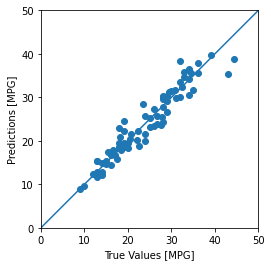

In [71]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


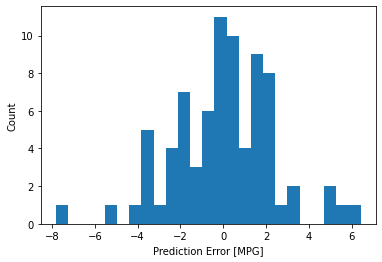

In [72]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [73]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [74]:
reloaded = tf.keras.models.load_model('dnn_model') 

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [75]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.655363
linear_model,2.501311
dnn_horsepower_model,2.903816
dnn_model,1.791284
reloaded,1.791284
